In [24]:
import os
import copy
import pickle
import random
import numpy as np
from matplotlib import pyplot as plt
import wandb
import torch
from torch.nn import Conv2d, Linear

wandb.init(mode="disabled")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch_pruning

In [ ]:
from torch_pruning.pruner.algorithms import ConvPruner, LinearPruner, BatchnormPruner, GroupNormImportance
from torch_pruning.pruner import MetaPruner, MagnitudePruner, GroupNormPruner, BNScalePruner, BasePruningFunc
from torch_pruning import L1Pruning, L2Pruning, MagnitudePruning, RandomGroupLassoPruning, BasePruningMethod
from torch.nn.modules.conv import Conv2d # from torch.nn import Conv2d, Linear
from torch.nn.modules.linear import Linear
class MyCustomPruning(BasePruningMethod):
    
    def __init__(self, amount):
        self.amount = amount

    def __call__(self, module):
        # Implement your custom pruning logic here
        # Access module weights, activations, gradients etc.
        # Return a mask indicating which weights to prune (0 for prune, 1 for keep)
        pass

In [5]:
from main import train_gd
from mnist import load_mnist
from data_fashion import load_fashion
from lenet import LeNet
from utilities import iterate_dataset, get_loss_and_acc

In [6]:
loss = "mse"
loss_fn, acc_fn = get_loss_and_acc(loss)
loss_fn.__setattr__("individual", False)
acc_fn.__setattr__("individual", False)
batch_size = 200

In [7]:
main_path = "/home/mateusz.pyla/stan/atelier/sharpness"

if not "RESULTS" in os.environ:
    os.environ["RESULTS"] = os.path.join(main_path, "results")
if not "DATASETS" in os.environ:
    os.environ["DATASETS"] = os.path.join(main_path, "data")

In [8]:
train, test = load_mnist(loss, os.environ["DATASETS"])
train_fashion, test_fashion = load_fashion(loss, os.environ["DATASETS"])

In [9]:
command_string = """ python src/main.py train gd mnist lenet mse
        --seed 3 --physical_batch_size 1000 --acc_goal 0.75 --load_step 0 
        --opt sgd --lr 0.01 --max_steps 1000 --neigs 2 --eig_freq 1 --abridged_size 1000 
        --save_model --save_freq 1 --analysis_mnist --analysis_gradcam --analysis_class_selectivity --analysis_perclass """

In [10]:
mnist_train_dict = {'dataset': "mnist", 'arch_id': 'lenet', 'loss': loss, 'opt': 'sgd', 'lr': 0.01, 'max_steps': 100,
              "seed": 10, "neigs": 2, "eig_freq": 1, "abridged_size": 1000,
              "save_model": True, "save_freq": 1}

In [11]:
fashion_train_dict = {'dataset': "fashion", 'arch_id': 'lenet', 'loss': loss, 'opt': 'sgd', 'lr': 0.01, 'max_steps': 100,
              "seed": 10, "neigs": 2, "eig_freq": 1, "abridged_size": 1000,
              "save_model": True, "save_freq": 1}

In [12]:
lst_seeds = [10, 11, 12, 13, 14]

output directory: /home/mateusz.pyla/stan/atelier/sharpness/results/fashion/lenet/mse/sgd/lr_0.01_delta0.0/seed_10/freq_1/start_0/
set torch seed: 10
train lenet of 61706 params with sgd on fashion using mse objective
0	0.492	0.058	0.492	0.058
0	eigenvalues:	tensor([1.8969, 1.6456])
1	0.456	0.114	0.456	0.117
1	eigenvalues:	tensor([1.8291, 1.6371])
2	0.448	0.190	0.448	0.194
2	eigenvalues:	tensor([1.9015, 1.6945])
3	0.445	0.284	0.445	0.288
3	eigenvalues:	tensor([2.0083, 1.7696])
4	0.443	0.408	0.443	0.410
4	eigenvalues:	tensor([2.1118, 1.8602])
5	0.439	0.464	0.439	0.464
5	eigenvalues:	tensor([2.2816, 1.9801])
6	0.435	0.470	0.435	0.473
6	eigenvalues:	tensor([2.5803, 2.1779])
7	0.429	0.470	0.429	0.469
7	eigenvalues:	tensor([3.1515, 2.5453])
8	0.419	0.471	0.420	0.470
8	eigenvalues:	tensor([4.2155, 3.3067])
9	0.407	0.472	0.407	0.472
9	eigenvalues:	tensor([6.1966, 5.1172])
10	0.390	0.481	0.391	0.481
10	eigenvalues:	tensor([9.9528, 8.6295])
11	0.373	0.502	0.373	0.505
11	eigenvalues:	tensor([15.

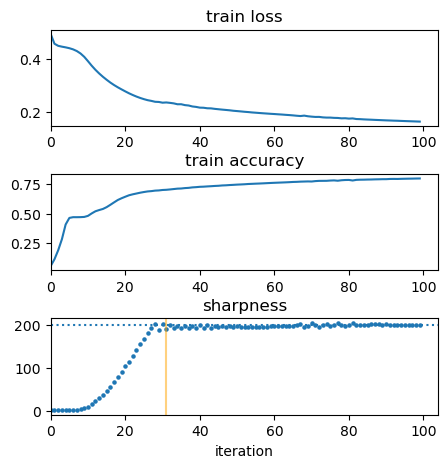

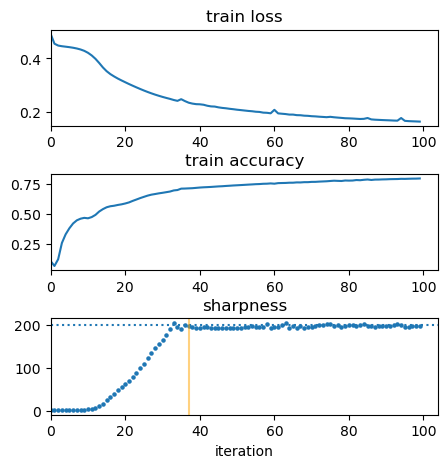

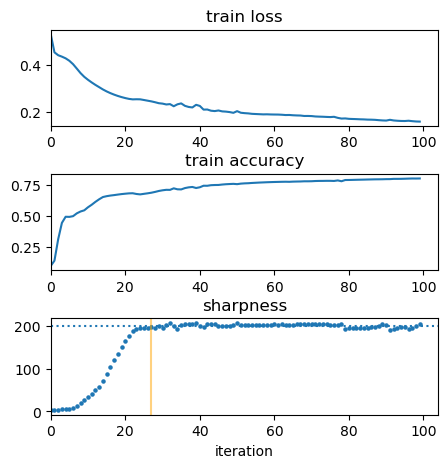

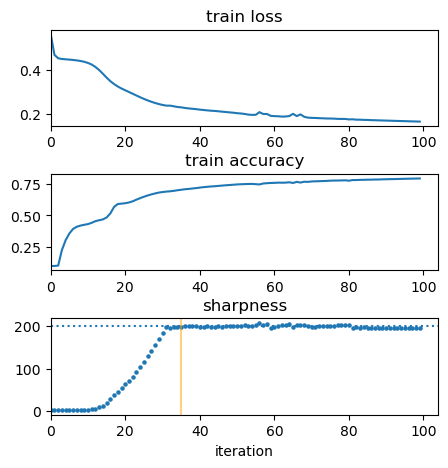

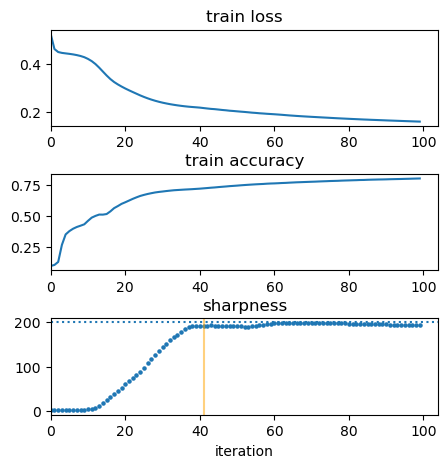

In [11]:
for seed in lst_seeds:
    fashion_train_dict["seed"] = seed
    train_gd(**fashion_train_dict)

In [13]:
def get_model_path(dataset, seed, step):
    return f"/home/mateusz.pyla/stan/atelier/sharpness/results/{dataset}/lenet/mse/sgd/lr_0.01_delta0.0/seed_{seed}/freq_1/start_0/model_snapshot_step_{step}"

In [14]:
def count_zero_parameters(model):
    zero_count = 0
    for param in model.parameters():
        if param is not None:
            zero_count += torch.sum(param == 0).item()
    return zero_count

In [15]:
def finetune(model, loss_fn, train_dataset, batch_size, lr, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    for e in range(epochs):
        running_loss = []
        for (X, y) in iterate_dataset(train_dataset, batch_size):
            opt.zero_grad()
            X.to(device)
            out = model(X)
            loss = loss_fn(out, y) / len(X)
            running_loss.append(loss.item())
            loss.backward()
            opt.step()

In [16]:
net = LeNet()
net.to(device)
finetune(net, loss_fn, train_fashion, 100, 0.01, 10)

In [17]:
def evaluate(model, test_dataset, batch_size=1000):
    with torch.no_grad():
        running_loss, running_acc = [], []
        for (X, y) in iterate_dataset(test_dataset, batch_size):
            X, y = X.to(device), y.to(device)

            loss = loss_fn(model(X), y) / len(X)
            acc = acc_fn(model(X), y) / len(X)

            running_loss.append(loss)
            running_acc.append(acc)

        return sum(running_loss)/len(running_loss), sum(running_acc)/len(running_acc)

In [18]:
lst_steps = [0, 5, 10, 20, 30, 50, 75, 99]
lst_percents = [0, 5, 10, 20, 30, 40, 50, 75, 90]
dataset = "fashion"
lst_types = [[LeNet]] # [[LeNet],[Conv2d, Linear], [Conv2d], [Linear]]

def is_one_of(value, types):
    """Checks if a value is one of the given types."""
    return any(isinstance(value, t) for t in types)

In [19]:
lst_pruning_methods = [torch_pruning.pruner.MagnitudePruner]
iterative_steps = 5
ex = test[0][0].unsqueeze(0).to(device)

In [23]:
d = {}
for seed in lst_seeds:
    for step in lst_steps:
        for percent in lst_percents:
            for i, types in enumerate(lst_types):
                for j, pruning_method in enumerate(lst_pruning_methods):
                    model = LeNet()
                    model.load_state_dict(torch.load(get_model_path(dataset, seed, step)))
                    model.to(device)

                    base_macs, base_nparams = torch_pruning.utils.count_ops_and_params(model, ex)

                    ignored_layers = []
                    for m in model.named_parameters():
                        if not is_one_of(m, types):
                            ignored_layers.append(m)
                
                    imp = torch_pruning.importance.MagnitudeImportance(p=2, group_reduction='mean')
                    this_pruning_method = pruning_method(model, ex, importance=imp, iterative_steps=iterative_steps, 
                                                        pruning_ratio=percent*0.01, global_pruning=False,
                                                        ignored_layers=ignored_layers)

                    for k in range(iterative_steps):
                        for group in this_pruning_method.step(interactive=True):
                            for dep, idxs in group:
                                target_layer = dep.target.module
                                pruning_fn = dep.handler
                                if pruning_fn in [torch_pruning.prune_conv_in_channels, torch_pruning.prune_linear_in_channels]:
                                    target_layer.weight.data[:, idxs] *= 0
                                elif pruning_fn in [torch_pruning.prune_conv_out_channels, torch_pruning.prune_linear_out_channels]:
                                    target_layer.weight.data[idxs] *= 0
                                    if target_layer.bias is not None:
                                        target_layer.bias.data[idxs] *= 0
                                elif pruning_fn in [torch_pruning.prune_batchnorm_out_channels]:
                                    target_layer.weight.data[idxs] *= 0
                                    target_layer.bias.data[idxs] *= 0
                                # group.prune() # <= disable hard pruning

                        pruned_macs, pruned_nparams = torch_pruning.utils.count_ops_and_params(model, ex)

                        nparams = count_zero_parameters(model)

                        sparsity = 1.0 - nparams / base_nparams

                        loss, acc = evaluate(model, test_fashion, batch_size)

                        finetune(model, loss_fn, train, 100, 0.01, 10)
                        loss_ft, acc_ft = evaluate(model, test, batch_size)

                        exp_name = f"s{seed}_c{step}_p{percent}_t{i}_m{j}_i{k}"
                        d[exp_name] = (acc, loss, sparsity, loss_ft, acc_ft)
        

13.716072628200054
2.336671462357044
1.6537524324655533
1.3432099790871144
1.1357867065320413
0.9993321441113949
0.8797239488363267
0.7986826450874408
0.6996118050441146
0.6434230994060636
0.5866522202516595
0.5249591543525457
0.468700246339043
0.42307351777950924
0.3785654056072235
0.36049409705524643
0.32750425186629095
0.29514871940637627
0.2690750321559608
0.24999718798324466
0.2364130894901852
0.2159578473555545
0.2023295536947747
0.18230574356392026
0.17591273257198434
0.1702983338541041
0.15967864787206054
0.15204359476144116
0.1406050436726461
0.1281271003993849
0.12029880824343611
0.11536618915076056
0.10404553199807803
0.10299141596226642
0.095729879400072
0.09219000288906197
0.09282813854205112
0.08608644591023525
0.08450276195071638
0.07768872580025345
0.0710704070624585
0.0712777791529273
0.06903162815685694
0.06897916736702124
0.06597593882509196
0.062212097329708435
0.06104545919845501
0.057213429938225695
0.05817960671770076
0.0548380308264556
45.58396212259928
45.40913

In [64]:
d

{'s10_c0_p0_t0_m0_i0': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i1': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i2': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i3': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i4': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p5_t0_m0_i0': (tensor(0.0975, device='cuda:0'),
  tensor(0.4959, device='cuda:0'),
  0.9240754545749198),
 's10_c0_p5_t0_m0_i1': (tensor(0.0980, device='cuda:0'),
  tensor(0.4959, device='cuda:0'),
  0.9145788091919749),
 's10_c0_p5_t0_m0_i2': (tensor(0.1055, device='cuda:0'),
  tensor(0.4959, device='cuda:0'),
  0.9051145755680161),
 's10_c0_p5_t0_m0_i3': (tensor(0.1056, device='cuda:0'),
  tensor(0.4965, device='cuda:0'),
  0.8956827537030435),
 's10_c0_p5_t0_m0_i4': (tensor(0.1012, d

In [ ]:
with open('saved_dictionary_soft_transfer_FtM.pkl', 'wb') as f:
    pickle.dump(d, f)

In [18]:
d

{'s10_c0_p0_t0_m0_i0': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i1': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i2': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i3': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t0_m0_i4': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t1_m0_i0': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t1_m0_i1': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t1_m0_i2': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t1_m0_i3': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),
 's10_c0_p0_t1_m0_i4': (tensor(0.0745, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  1.0),


In [22]:
with open('/home/mateusz.pyla/stan/atelier/sharpness/src/saved_dictionary_soft_transferFtoM.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [53]:
model = LeNet()
model.load_state_dict(torch.load(get_model_path("fashion", 10, 10)))
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
def aggregate_results_by_checkpoints_of_percent_avgstd(d):
    rez_acc = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
    rez_los = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]

    for iter_seed, seed in enumerate(lst_seeds):
        for iter_step, step in enumerate(lst_steps):
            for iter_percent, percent in enumerate(lst_percents):
                types = 0
                i = 0
                j = 0
                k = 0
                exp_name = f"s{seed}_c{step}_p{percent}_t{i}_m{j}_i{k}"
                acc, loss, _ = d[exp_name]
                rez_acc[iter_step][iter_percent][iter_seed] = acc.item()
                rez_los[iter_step][iter_percent][iter_seed] = loss.item()

    rez_acc_mean = np.mean(rez_acc, axis=-1)
    rez_acc_std = np.std(rez_acc, axis=-1)
    rez_los_mean = np.mean(rez_los, axis=-1)
    rez_los_std = np.std(rez_los, axis=-1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle("MNIST Soft MagnitudePruner 5steps WholeNet ")
    colors = plt.cm.viridis(np.linspace(0, 1, len(lst_steps)))

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        ax1.plot(lst_percents, rez_acc_mean[i], label=f'Checkpoint {c}', color=color)
        ax1.fill_between(lst_percents, rez_acc_mean[i] - rez_acc_std[i], rez_acc_mean[i] + rez_acc_std[i], color=color, alpha=0.2)

    ax1.set_title('Accuracy')
    ax1.set_xlabel('Strength sparsity')
    ax1.legend()

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        ax2.plot(lst_percents, rez_los_mean[i], label=f'Checkpoint {c}', color=color)
        ax2.fill_between(lst_percents, rez_los_mean[i] - rez_los_std[i], rez_los_mean[i] + rez_los_std[i], color=color, alpha=0.2)

    ax2.set_title('Loss')
    ax2.set_xlabel('Strength sparsity')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [28]:
def aggregate_results_by_checkpoints_of_percent_avgstd_transfer(d):
    rez_acc = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
    rez_los = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
    rez_acc_ft = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
    rez_los_ft = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
    rez_sparsity = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]

    for iter_seed, seed in enumerate(lst_seeds):
        for iter_step, step in enumerate(lst_steps):
            for iter_percent, percent in enumerate(lst_percents):
                types = 0
                i = 0
                j = 0
                k = 4
                exp_name = f"s{seed}_c{step}_p{percent}_t{i}_m{j}_i{k}"
                acc, loss, sparsity, acc_ft, loss_ft = d[exp_name]
                rez_acc[iter_step][iter_percent][iter_seed] = acc.item()
                rez_los[iter_step][iter_percent][iter_seed] = loss.item()
                rez_acc_ft[iter_step][iter_percent][iter_seed] = acc_ft.item()
                rez_los_ft[iter_step][iter_percent][iter_seed] = loss_ft.item()
                rez_sparsity[iter_step][iter_percent][iter_seed] = sparsity

    rez_acc_mean = np.mean(rez_acc, axis=-1)
    rez_acc_std = np.std(rez_acc, axis=-1)
    rez_los_mean = np.mean(rez_los, axis=-1)
    rez_los_std = np.std(rez_los, axis=-1)
    rez_acc_ft_mean = np.mean(rez_acc_ft, axis=-1)
    rez_acc_ft_std = np.std(rez_acc_ft, axis=-1)
    rez_los_ft_mean = np.mean(rez_los_ft, axis=-1)
    rez_los_ft_std = np.std(rez_los_ft, axis=-1)
    rez_sparsity_mean = np.mean(rez_sparsity, axis=-1)
    rez_sparsity_std = np.std(rez_sparsity, axis=-1)

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle("MNIST Soft MagnitudePruner 5steps WholeNet ")
    colors = plt.cm.viridis(np.linspace(0, 1, len(lst_steps)))

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        axs[0,0].plot(lst_percents, rez_acc_mean[i], label=f'Checkpoint {c}', color=color)
        axs[0,0].fill_between(lst_percents, rez_acc_mean[i] - rez_acc_std[i], rez_acc_mean[i] + rez_acc_std[i], color=color, alpha=0.2)

    axs[0,0].set_title('Accuracy')
    axs[0,0].set_xlabel('Strength sparsity')
    #axs[0,0].legend()

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        axs[0,1].plot(lst_percents, rez_los_mean[i], label=f'Checkpoint {c}', color=color)
        axs[0,1].fill_between(lst_percents, rez_los_mean[i] - rez_los_std[i], rez_los_mean[i] + rez_los_std[i], color=color, alpha=0.2)

    axs[0,1].set_title('Loss')
    axs[0,1].set_xlabel('Strength sparsity')
    #axs[0,1].legend()

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        axs[1,0].plot(lst_percents, rez_acc_ft_mean[i], label=f'Checkpoint {c}', color=color)
        axs[1,0].fill_between(lst_percents, rez_acc_ft_mean[i] - rez_acc_ft_std[i], rez_acc_ft_mean[i] + rez_acc_ft_std[i], color=color, alpha=0.2)

    axs[1,0].set_title('Accuracy FT')
    axs[1,0].set_xlabel('Strength sparsity')
    #axs[1,0].legend()

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        axs[1,1].plot(lst_percents, rez_los_ft_mean[i], label=f'Checkpoint {c}', color=color)
        axs[1,1].fill_between(lst_percents, rez_los_ft_mean[i] - rez_los_ft_std[i], rez_los_ft_mean[i] + rez_los_ft_std[i], color=color, alpha=0.2)

    axs[1,1].set_title('Loss FT')
    axs[1,1].set_xlabel('Strength sparsity')
    #axs[1,1].legend()

    for i, (c, color) in enumerate(zip(lst_steps, colors)):
        axs[2,0].plot(lst_percents, rez_sparsity_mean[i], label=f'Checkpoint {c}', color=color)
        axs[2,0].fill_between(lst_percents, rez_sparsity_mean[i] - rez_sparsity_std[i], rez_sparsity_mean[i] + rez_sparsity_std[i], color=color, alpha=0.2)

    axs[2,0].set_title('Non-zero weights')
    axs[2,0].set_xlabel('Strength sparsity')
    #axs[2,0].legend()

    axs[2,1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

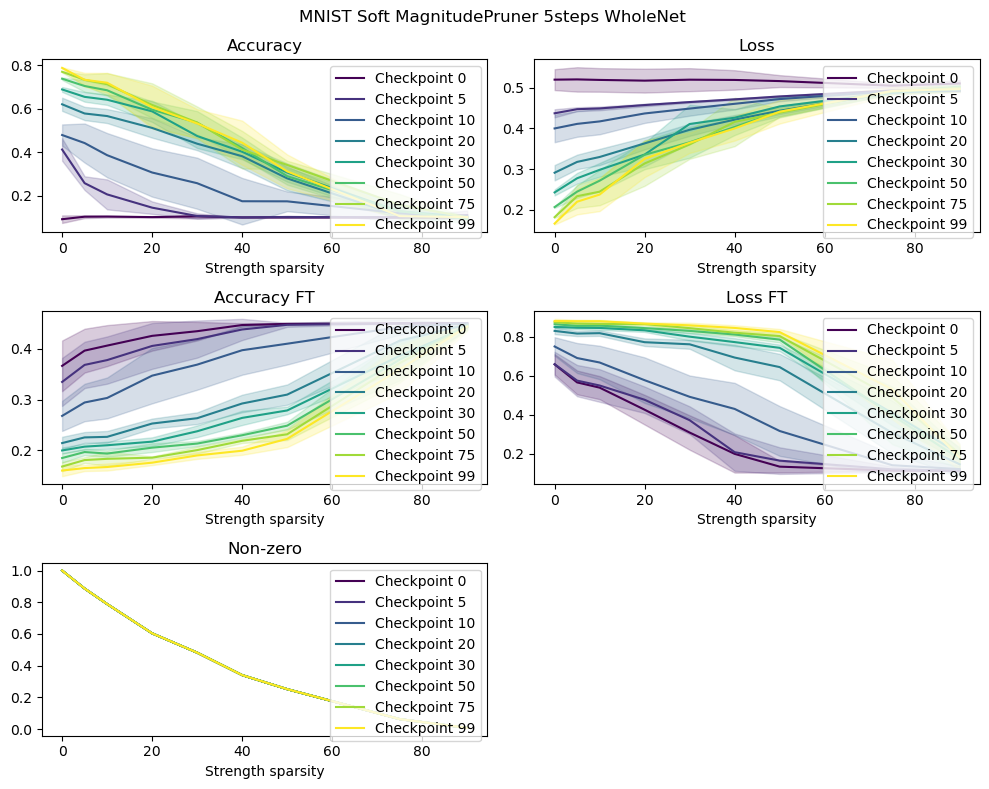

In [29]:
aggregate_results_by_checkpoints_of_percent_avgstd_transfer(loaded_dict)

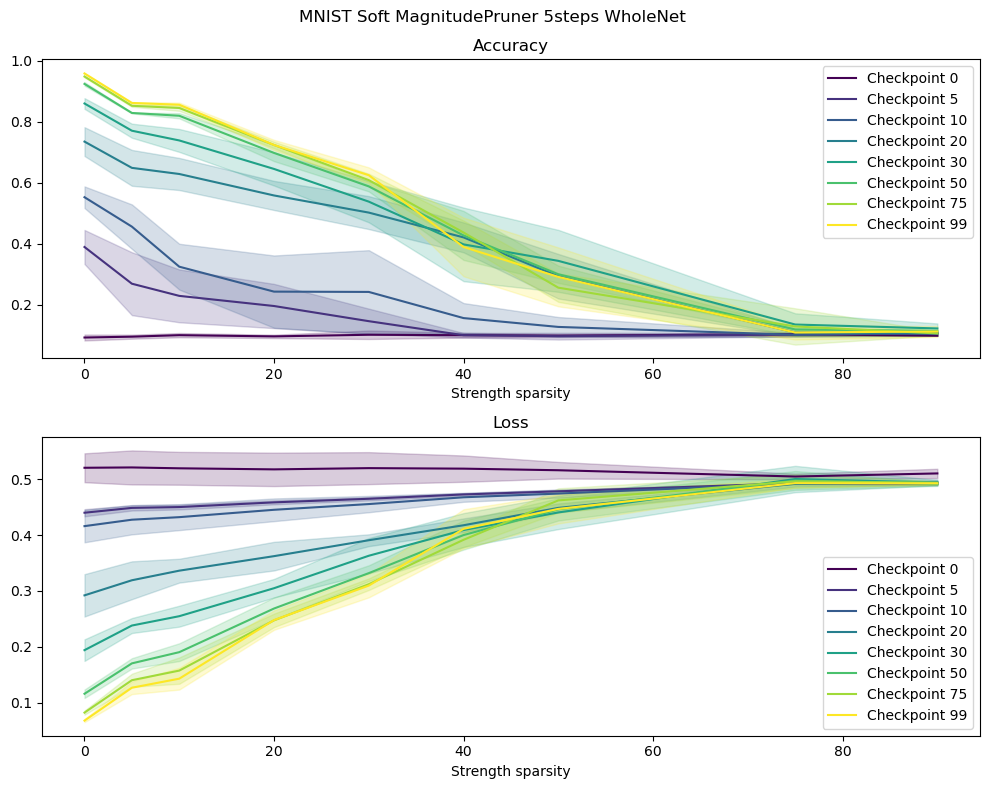

In [67]:
aggregate_results_by_checkpoints_of_percent_avgstd(loaded_dict)

In [61]:
rez_acc = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]
rez_los = [[[0.0 for s in lst_seeds] for p in lst_percents] for c in lst_steps]

for iter_seed, seed in enumerate(lst_seeds):
    for iter_step, step in enumerate(lst_steps):
        for iter_percent, percent in enumerate(lst_percents):
            types = 0
            i = 0
            j = 0
            k = 4
            exp_name = f"s{seed}_c{step}_p{percent}_t{i}_m{j}_i{k}"
            acc, loss, _ = loaded_dict[exp_name]
            rez_acc[iter_step][iter_percent][iter_seed] = acc.item()
            rez_los[iter_step][iter_percent][iter_seed] = loss.item()

In [62]:
rez_acc_mean = np.mean(rez_acc, axis=-1)
rez_acc_std = np.std(rez_acc, axis=-1)
rez_los_mean = np.mean(rez_los, axis=-1)
rez_los_std = np.std(rez_los, axis=-1)

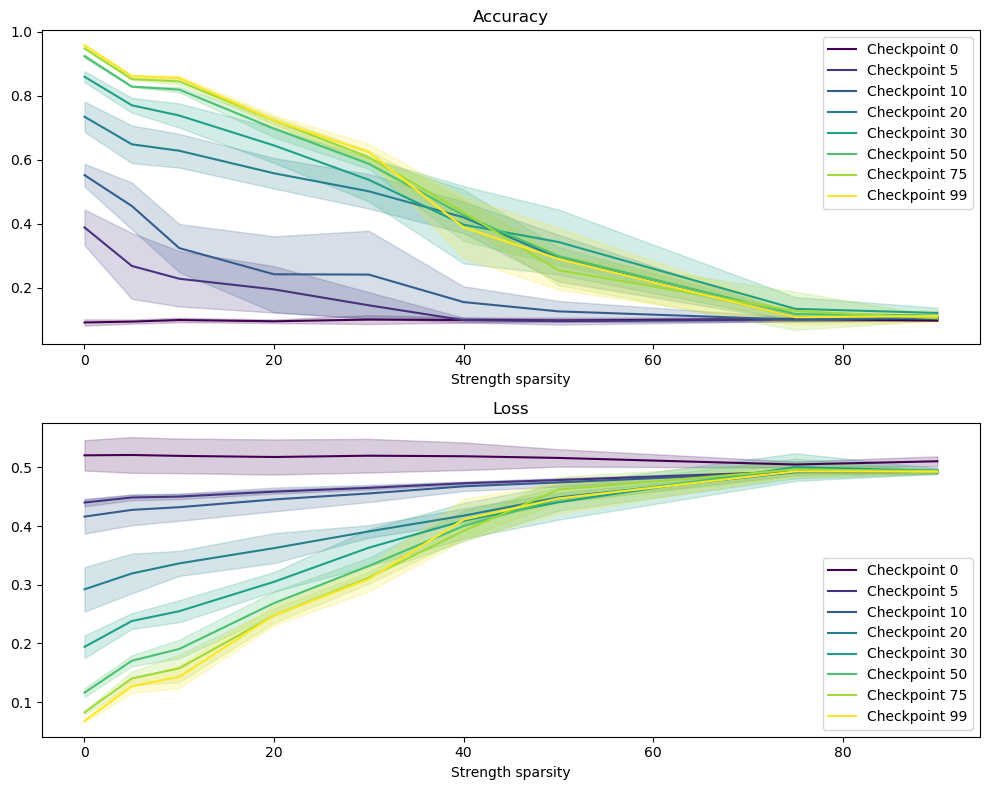

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("MNIST Soft MagnitudePruner 5steps WholeNet ")
colors = plt.cm.viridis(np.linspace(0, 1, len(lst_steps)))

for i, (c, color) in enumerate(zip(lst_steps, colors)):
    ax1.plot(lst_percents, rez_acc_mean[i], label=f'Checkpoint {c}', color=color)
    ax1.fill_between(lst_percents, rez_acc_mean[i] - rez_acc_std[i], rez_acc_mean[i] + rez_acc_std[i], color=color, alpha=0.2)

ax1.set_title('Accuracy')
ax1.set_xlabel('Strength sparsity')
ax1.legend()

for i, (c, color) in enumerate(zip(lst_steps, colors)):
    ax2.plot(lst_percents, rez_los_mean[i], label=f'Checkpoint {c}', color=color)
    ax2.fill_between(lst_percents, rez_los_mean[i] - rez_los_std[i], rez_los_mean[i] + rez_los_std[i], color=color, alpha=0.2)

ax2.set_title('Loss')
ax2.set_xlabel('Strength sparsity')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# lotery ticket
